#  **Heart Failure Clinical Records Dataset Model Evaluation and Interpretation**

**Objective**  
Evaluate the performance of the best trained model (Random Forest) on the hold-out test set using classification metrics, ROC/PR curves, calibration plots, and interpretability tools (SHAP, LIME).

In [1]:
import joblib
import lime
import lime.lime_tabular
import shap
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, f1_score, accuracy_score, precision_score, recall_score, brier_score_loss
from sklearn.calibration import calibration_curve


sns.set(style='whitegrid', font_scale=1.2)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


RANDOM_STATE = 42


In [2]:
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()
X_train = pd.read_csv('../data/processed/X_train.csv')
rf_model = joblib.load('../models/best_model.pkl')


##  **Make Predictions**

In [3]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

##  **Performance Metrics**

In [4]:
print("Classification Report\n", classification_report(y_test, y_pred))

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'AUROC': roc_auc_score(y_test, y_pred_proba),
    'Brier Score': brier_score_loss(y_test, y_pred_proba)
}

pd.Series(metrics).round(4)


Classification Report
               precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60



Accuracy       0.8333
F1 Score       0.7059
Precision      0.8000
Recall         0.6316
AUROC          0.8768
Brier Score    0.1307
dtype: float64

## **ROC Curve**

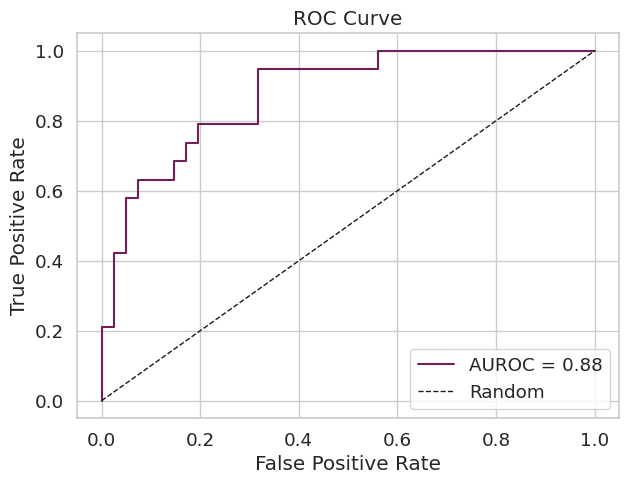

In [5]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUROC = {metrics["AUROC"]:.2f}', color=sns.color_palette('rocket', as_cmap=False)[1])
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Precision-Recall Curve**

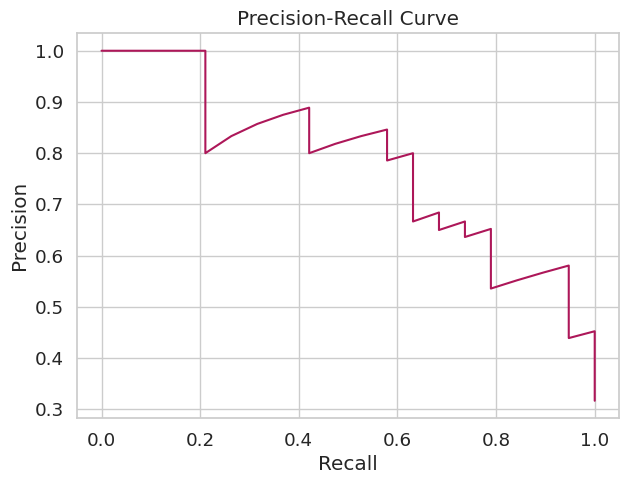

In [6]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color=sns.color_palette('rocket', as_cmap=False)[2])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


## **Confusion Matrix**

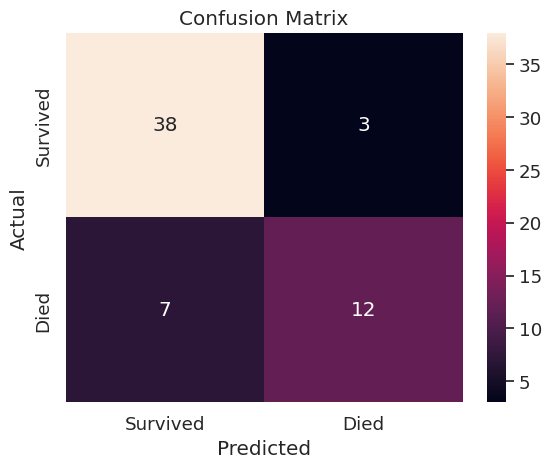

In [7]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


##  **Calibration Plot**

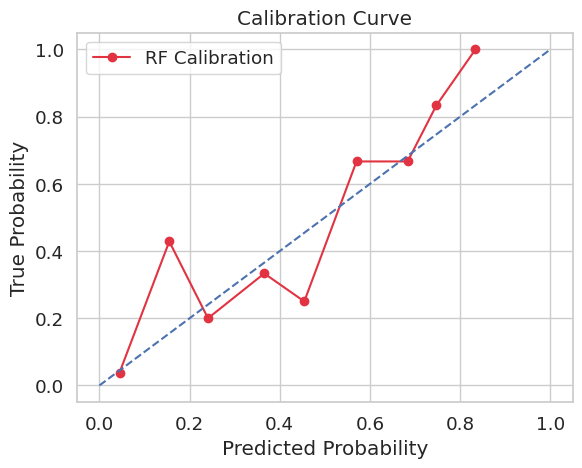

In [8]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='RF Calibration', color=sns.color_palette('rocket', as_cmap=False)[3])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()


##  **Model Interpretation with SHAP**

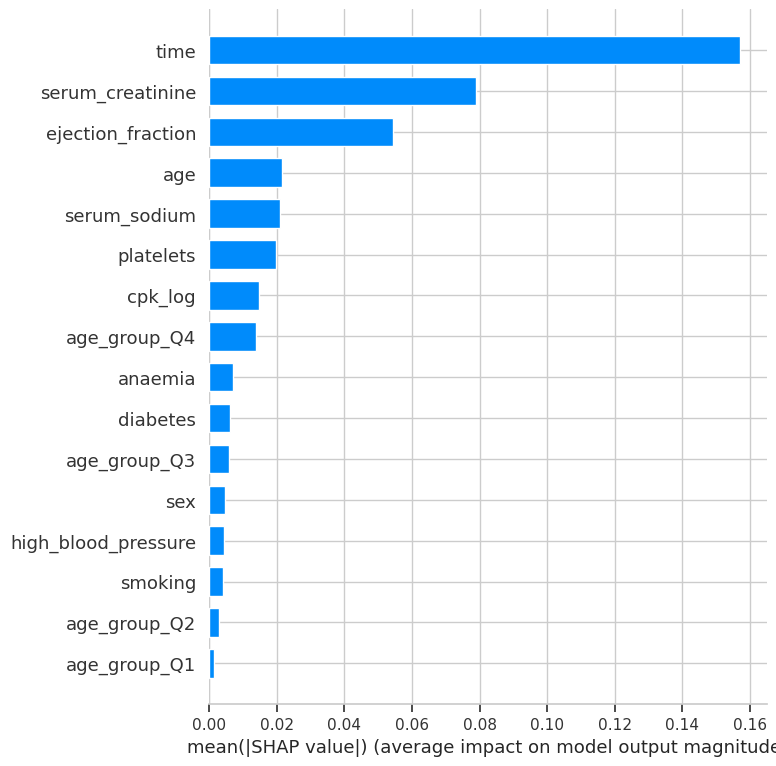

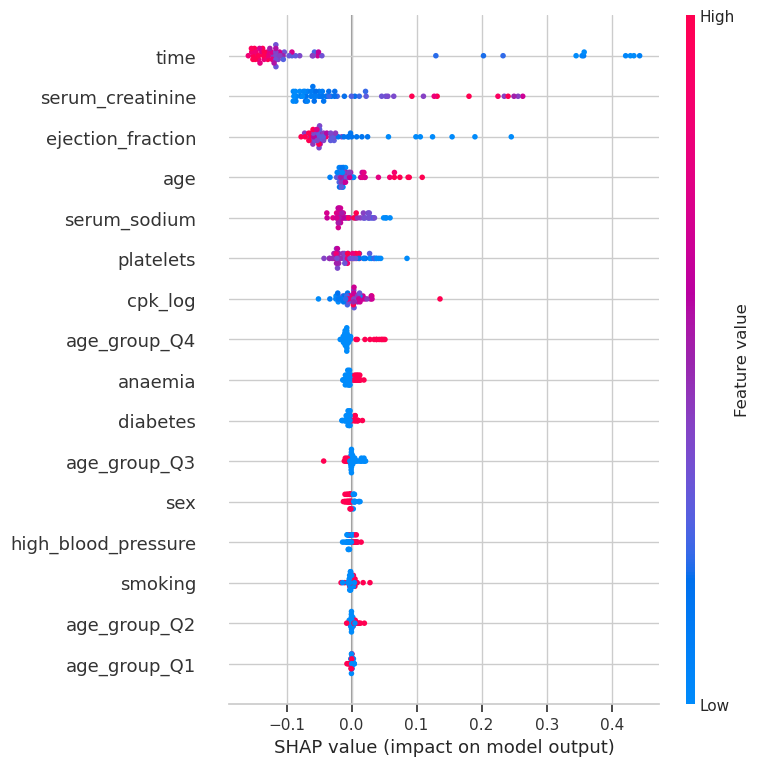

In [9]:
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test, check_additivity=False)

shap.summary_plot(shap_values[..., 1], X_test, plot_type='bar')
shap.summary_plot(shap_values[..., 1], X_test)


In [10]:
joblib.dump(explainer, '../models/shap_explainer.pkl')
joblib.dump(shap_values, '../models/shap_values.pkl')

['../models/shap_values.pkl']

## **Patient-level Explainability with LIME**

Intercept 0.3730584932104482
Prediction_local [0.29962338]
Right: 0.13349320543565146


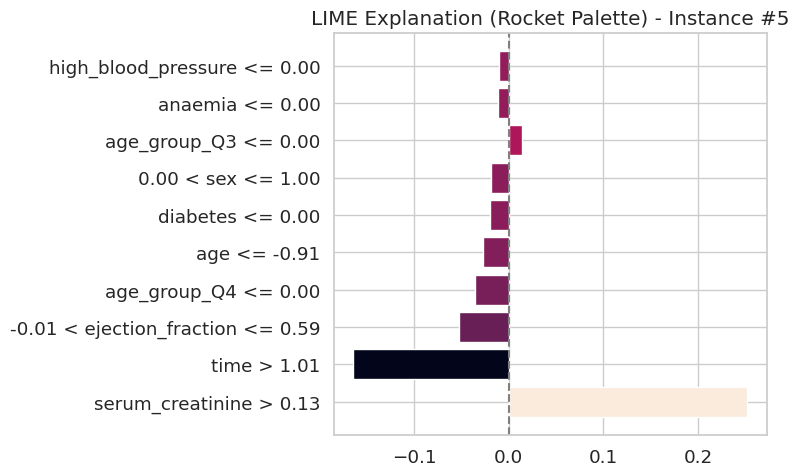

Intercept 0.24025844243362066
Prediction_local [0.51739243]
Right: 0.6865707434052758


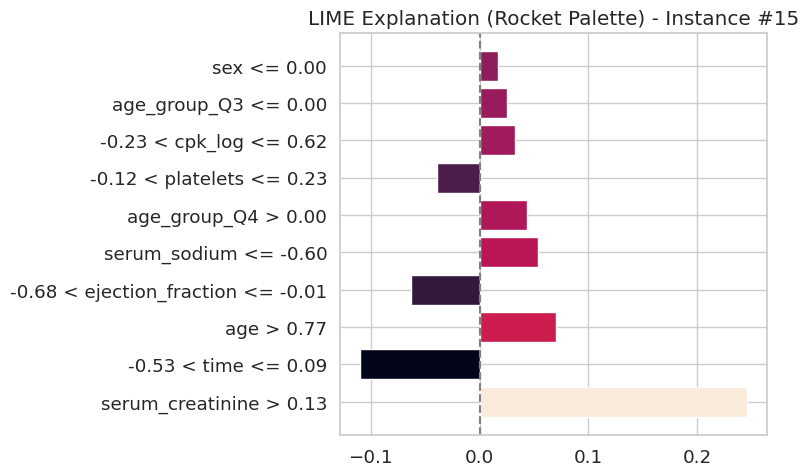

Intercept 0.3365689137032716
Prediction_local [0.35616999]
Right: 0.47926515930113067


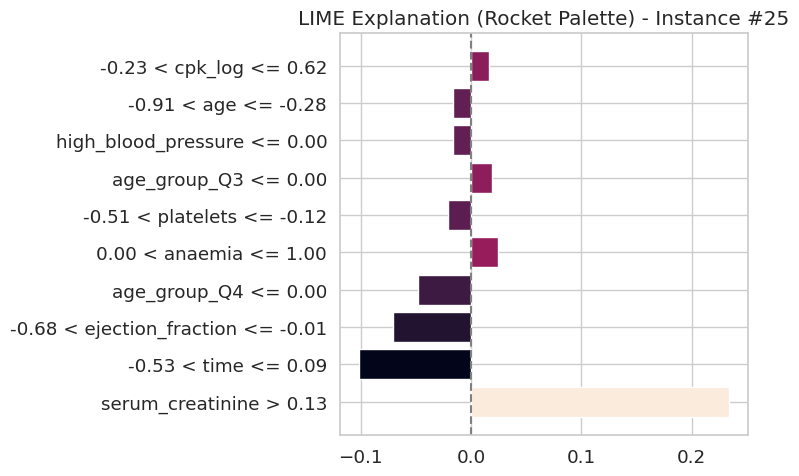

Intercept 0.23102805426153838
Prediction_local [0.69966866]
Right: 0.77757793764988


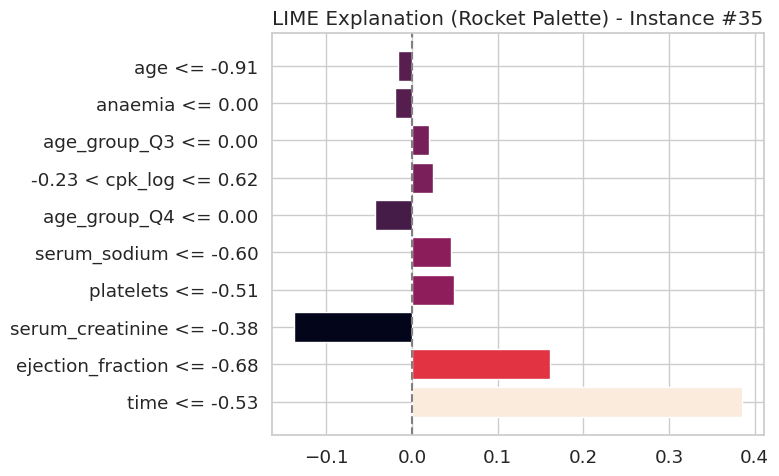

In [11]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test.values,
    feature_names=X_test.columns.tolist(),
    class_names=['Survived', 'Died'],
    mode='classification',
    discretize_continuous=True,
    verbose=True
)

rocket_palette = sns.color_palette("rocket", as_cmap=True)

def plot_lime_rocket(explanation, instance_index):
    exp = explanation.as_list()
    labels, weights = zip(*exp)
    weights = np.array(weights)
    colors = rocket_palette((weights - weights.min()) / (weights.max() - weights.min() + 1e-8))

    fig, ax = plt.subplots(figsize=(8, len(exp) * 0.5))
    ax.barh(range(len(exp)), weights, color=colors)
    ax.set_yticks(range(len(exp)))
    ax.set_yticklabels(labels)
    ax.set_title(f'LIME Explanation (Rocket Palette) - Instance #{instance_index}')
    ax.axvline(0, color='grey', linestyle='--')
    plt.tight_layout()
    plt.show()

for i in [5, 15, 25,35]:
    explanation = lime_explainer.explain_instance(
        data_row=X_test.iloc[i].values,
        predict_fn=rf_model.predict_proba
    )
    plot_lime_rocket(explanation, i)


Patient-specific explanations using LIME reveal consistent and clinically coherent patterns that reinforce the global model logic. In all four patient cases, elevated serum creatinine (serum_creatinine > 0.13) appears as a dominant risk factor, contributing positively to the predicted probability of death. This underscores the critical role of renal dysfunction as a key determinant of poor prognosis in heart failure.

In the 5th patient (prediction ≈ 0.24), despite the high risk from creatinine, mitigating factors such as longer follow-up duration (time > 1.01), moderate to preserved EF (ejection_fraction > -0.01), and younger age (age <= -0.91) collectively reduce mortality risk. The model weighs these protective features against creatinine to produce a lower risk prediction.

In contrast, the 15th patient (prediction ≈ 0.47) shows added risk from older age (age > 0.77) and hyponatremia (serum_sodium <= -0.60), with limited follow-up time, pushing the prediction higher. Similarly, the 25th patient (prediction ≈ 0.31) again sees creatinine driving risk, counterbalanced by moderate EF and longer survival time.

The 35th patient (prediction ≈ 0.68) is flagged as high-risk primarily due to very short follow-up (time <= -0.53) and severely reduced EF (ejection_fraction <= -0.68), both of which are potent markers of acute decompensation. Although this patient has low creatinine, it's insufficient to outweigh the severe cardiac indicators and hyponatremia.

Across all cases, LIME highlights temporal variables (time), ejection fraction, serum creatinine, and electrolyte status (serum sodium) as consistent influencers, with demographic modifiers (age group, sex) providing subtle risk adjustments. These local explanations reinforce the model’s alignment with known clinical physiology in heart failure, suggesting it could offer transparent, patient-level reasoning to support bedside decision-making.